In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression as SKLearnLogsiticRegression 
from sklearn.ensemble import RandomForestClassifier as SKLearnRandomForestClassifier

# modeling libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, recall_score, precision_score, PrecisionRecallDisplay, make_scorer, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# cm plotting library
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

# diff priv libarries
import opendp.smartnoise.core as sn
from diffprivlib.models import LogisticRegression, RandomForestClassifier

# suppress warnings for final report
import warnings
warnings.filterwarnings('ignore')

# specify some plot settings
plt.style.use('fivethirtyeight')
COLOR = "#fffefc"

<a name='top'></a>
# Differential Privacy - Predicting Uninsured Residents in Massachusetts

Click [HERE](https://www.canva.com/design/DAE_5iKEKTc/IIhY3KvHlZrkUtt4ldvS2w/view?utm_content=DAE_5iKEKTc&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink) for our slides!

Click [HERE](https://www.youtube.com/watch?v=haCcAWNiofA) for our Youtube Video!

## Table of Contents

1. [Background](#background)
    1. [Merging Datasets](#merging)
    2. [Creating Y Variable](#creatingY) 
2. [Differential Privacy](#diffpriv)
3. [EDA Findings (From Milestone 2)](#eda)
    1. [Class Imbalance](#imbalance)
    2. [Missing Data](#missing)
    3. [Multicollinearity](#multico)
4. [Pre-processing](#processing)
    1. [Removing Non-Int Columns](#object)
    2. [Handling Majority Missing Data Columns](#handmissing)
    3. [Train/Test Split](#tts)
    4. [Imputation](#imputation)
    5. [Synthetic Minority Oversampling Technique (SMOTE)](#smote)
    6. [Principal Component Analysis](#pca)
5. [Modeling](#moedeling)
    1. [Metrics](#metrics)
    2. [Approach](#approach)
    3. [DP in Modeling](#constrains)
    4. [Logistic Regression](#logreg)
    5. [Random Forest](#rf)
    46. [Model Summaries](#summary)
6. [Challenges & Next Steps](#conclusion)
7. [References](#reference)

<a id='background'></a>
## 1. Background

#### Context
The State of Massachusetts is building a model to predict which residents are currently not protected by a health care plan. To better understand which residents are most at risk of being left uninsured, the State wants to create a machine learning model based on the U.S. Census data.

#### Motivation
The end goal is to reach out to these uninsured individuals to inform them of no-cost plans provided by the State, while also protecting all individuals' privacy in the data modelling and prediction process. 

#### Goal Statement
1. Accurate predictions: a classification model that can generate accurate binary predictions regarding the health insurance coverage of an individual
2. Differential privacy: a model that has a modified training process so that the model is differentially private: it is impossible to reverse-engineer the identity of the individuals in the dataset through "leaking" statistical summaries and other methods

#### Data Background

We have found two types of data on the given United States Census website. One database includes
individual-level information, while the other database includes family-level information. Upon closer
investigation, merging these two datasets together to enrich the results proved fairly simple as we had clear instruction from the census website on which columns to merge on.

The Public Use Microdata Sample (PUMS) dataset is created by the United States Census Bureau for public usage. Our team has used the individual-level data for the state of Massachusetts containing 335 thousand observations (for 335 thousand individuals) and 288 variables. Data was downloaded in a "csv" format directly from the Census Bureau website and uploaded to the team's private GitHub repository for further usage. The Census Bureau has enabled disclosure protection on the PUMS dataset so that individuals or housing units cannot be identified, however our team added additional guards to protect differential privacy during the model building process.

The individual-level data includes 335 thousand observations and 288 variables. To start making sense of the
data, we first processed the target variable, which is a binary variable describing whether the individual has
health insurance or not. We created a single column with the target variable, by reconciling 13 other columns
including various columns containing insurance information. For instance, columns “FHINSxx” include
information on Medicare, while “PRIV-” and “PUBCOV” columns includes private and public health insurance
information. We learned the individual columns’ descriptions from the US Census website, and applying that
logic, we created one final insurance column. As a final step we have removed all the other columns including
insurance information from the database.

After creating the target variable, we looked at the predictor variables. We have found that several columns do
not have any description on the US Census website, nor could we find information online after a Google
search. Such a group of columns was “PWGTPx”. In order to focus our efforts on the variable we are
comfortable with, we removed these unidentifiable columns.
Finally, we looked at the columns for which we had an understanding of the data they contain. These typically
included categorical as well as continuous data. The information covered included data regarding education,
earnings, demographics, and more.


<a id='merging'></a>
### 1A. Merging Datasets

See the below code for how we merged the personal and household datasets; this method was provided by the census website:

In [2]:
# read in hma and pma datasets (household and personal)
hma_df = pd.read_csv('data/psam_h25.csv')
pma_df = pd.read_csv('data/psam_p25.csv')

# create joined dataset, per instructions from census website
joined_df = pd.merge(hma_df, pma_df, on='SERIALNO', how='right', suffixes=('_H', '_P'))

<a id='creatingY'></a>
### 1B. Creating Y Variable

See the below function `create_insurance_var` for how we created the Y variable in the dataset; this methodology tracks with the descriptions provided for these fields from the census website.

In [3]:
# code for creating our Y Variable

def create_insurance_var(joined_df):
    
    # deep copy to ensure no pandas issues
    df = joined_df.copy(deep=True)
    
    # health insurance columns
    hs_cols = ["FHINS3C", "FHINS4C", "FHINS3C", "HICOV", "HINS1", "HINS2", "HINS3", "HINS4", "HINS5", "HINS6", "HINS7", "PRIVCOV", "PUBCOV"]
    hs_df = df[hs_cols]
    
    # check the insureance cols & create Y
    Y = []
    for idx, row in hs_df.iterrows():
        # insured
        if 1 in set(row):
            Y.append(1)
        # uninsured
        else:
            Y.append(0)
    
    # add insurance coverage col
    df['INSURANCE_COVERAGE'] = Y
    
    # remove insurance cols from df
    df = df.drop(hs_cols, axis=1)
    
    return df

# breaking point, so lets save data to csv
df = create_insurance_var(joined_df)
df.to_csv("data/merged_data.csv", index=False)

<a id='diffpriv'></a>
## 2. Differential Privacy (DP)

To understand Differential Privacy (DP) we need to first understand general computation privacy. Computational privacy consists of the following three main concepts:

1. Security
2. Regulatory
3. Data Sharing --> *Primary concern of DP*

DP is a rigorous mathematical definition of privacy that prevents leaking information via data visualization and statistical summaries. In DP we don't change the base dataset, but rather guarantee through algorithm adjustments that the process does not reveal personal information about any individual in the data. The results of the data should hardly change given a single individual entering or leaving the dataset. Census data provides a useful case of when to use DP, especially when dealing with smaller towns where the number of people is statistically small enough that identifying any one particular person may actually not be that difficult.

In the problem proposed today we are attempting to solve a Binary Classification machine learning algorithm where we are trying to predict whether a resident is insured or uninsured -- throughout the report you will see areas where DP practices were used to change a visualization or a statistic and how DP was incorporated into our algorithms to ensure privacy for users.

The use of a couple of key libraries that help abstract out some of the difficulty of DP will be used and they are the following:

1. SmartNoise: https://pypi.org/project/opendp-smartnoise-core/
2. Diffprivlib: https://diffprivlib.readthedocs.io/en/latest/index.html

[Back to Top](#top)

<a id='eda'></a>
## 3. EDA Findings

<a id='imbalance'></a>
### 3A. Class Imbalance

As explained above, one of the main goals of this project will be to create an explainable model to determine
whether a resident in Massachusetts (MA) has health insurance or not. Massachusetts is unique in the United
States (US) in that it requires nearly all of its residents to hold healthcare, and in cases where residents make
less than 150% of the federal poverty level, the state will
subsidize the cost for its residents. This program has been
very effective leading MA to have the lowest population of
uninsured residents of any state in the US. This is also
clear in the census data that we have. See the below chart
displaying the number of uninsured vs insured residents in
the state of MA. As expected with the high rate of insured
residents in MA, the chart displays the major class
imbalance in the dataset. This class imbalance will need
to be dealt with by random sampling up the Not Insured
residents and sampling down the Insured rows to try and
create a more artificial balance in the data. If accuracy
was a general metric to be used in the model evaluation, a
score of greater than 97.7% would need to be achieved to
simply beat predicting Insured for every single resident.
Due to the class imbalance and importance of being able
to predict Not Insured, perhaps precision/recall will be
better suited metrics for the evaluation.

[Back to Top](#top)


In [4]:
df = pd.read_csv("data/merged_data.csv")

# USE DP TO PRINT OUT SUMMARY STAT OF PREDICITNG JUST INSRUED!
with sn.Analysis() as analysis:
    insurance_dt = sn.to_float(df['INSURANCE_COVERAGE'])
    insurance_col_mean = sn.dp_mean(data=insurance_dt, privacy_usage={'epsilon': .004})

print(f"Predicting just Insured would give us Accuracy of without DP! {np.mean(df.INSURANCE_COVERAGE)}")
print(f"Predicting just Insured would give us Accuracy of with DP! {insurance_col_mean.value}")

Predicting just Insured would give us Accuracy of without DP! 0.9770072448644942
Predicting just Insured would give us Accuracy of with DP! 0.9770072448644942


Note a small but important note about what we just printed out. For purposes of an example we printed out the mean of our predictor column to identify how if we just predict insured our model will have a high accuracy, however we didn't just print out that value. We first added a bit of noise into the data to comply with DP. Now in this case it appears our dataset is big enough that adding in some noise didn't change the outcome much, but you will see throughout the report how we use DP to change these summary type stats.

### Will Plotting a Histogram of Insured vs. Uninsured Violate DP?!

Turns out a simple histogram summarizing the counts of insured vs uninsured could tell you more than you think! Let's think of a very simplistic example. Let's say we had made this histogram for the small (made-up) town of `Group39 Town` and the only people who live there are Vivien, Nikhil, Susan and Sam. Say this plot gets made for that county and 3 people have insurance and 1 doesn't have insurance. Say Susan is looking at the chart and she says *"Well.... I know that I have insurance, and I also know that Nikhil has insurance because Nikhil's employer provides them insurance"* -- Now Susan knows that the only two people that might be uninsured are Sam & Vivien. Although this is a small example, both Vivien and Sam's privacy have been compromised!

To summarize, it is good to think that any aggregate statistic that is left unmodified will violate DP! 

For purposes of the example let's first look at the histogram with no DP (violation!):


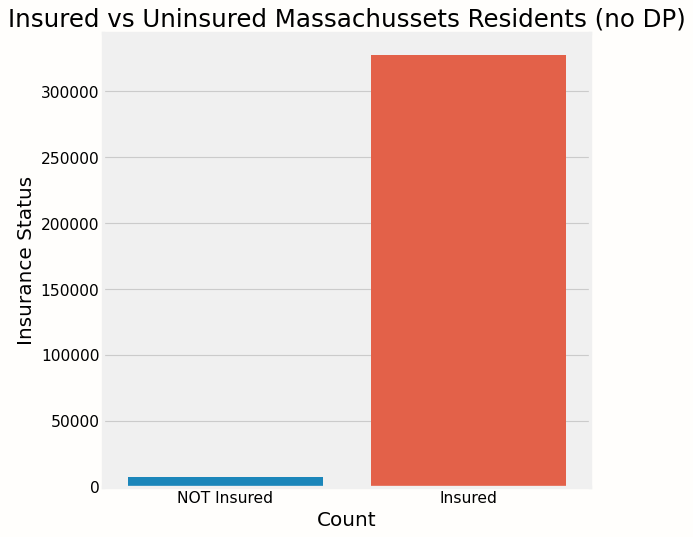

In [5]:
# plot imbalanced data, with no DP (VIOLATION!)
fig = figure(figsize=(7, 7), dpi=80)
fig.patch.set_facecolor(COLOR)
g = sns.countplot(df['INSURANCE_COVERAGE'])
g.set_xticklabels(['NOT Insured','Insured'])
plt.rcParams['axes.facecolor'] = COLOR
plt.title("Insured vs Uninsured Massachussets Residents (no DP)", fontsize=22)
plt.ylabel("Insurance Status", size=18)
plt.xlabel("Count", size=18)
plt.show() 

Next, let's add in some noise using the `smartnoise` library to ensure that we can present similar data without compromising any 1 individual. There are multiple methods for adding in diff privacy into the data to safely visualize. The geometric mehhanism only returns integer values for any query, so resists some vulnerabilities of DP releases from floating point approximations. Laplace mechanism is also shown below:


In [6]:
with sn.Analysis(protect_floating_point=False) as anyalysis:  
    
    # geometric method
    insurance_histogram = sn.dp_histogram(
                sn.to_bool(df['INSURANCE_COVERAGE'], true_label=0),
                privacy_usage = {'epsilon': 0.009}
            )
    
    # laplace method
    insurance_prep = sn.histogram(sn.to_bool(df['INSURANCE_COVERAGE'], true_label=0), null_value = True)
    insurance_histogram2 = sn.laplace_mechanism(insurance_prep, privacy_usage={"epsilon": 0.009, "delta": .000001})
    
anyalysis.release()

print("Insurance histogram Geometric DP release:      " + str(insurance_histogram.value))
print("Insurance histogram Laplace DP release:        " + str(insurance_histogram2.value))
print("Insurance histogram True Values release:        " + str(df.INSURANCE_COVERAGE.value_counts().values))

Insurance histogram Geometric DP release:      [327608   7780]
Insurance histogram Laplace DP release:        [327679.62256544   7856.29399369]
Insurance histogram True Values release:        [327698   7712]


From the outputs above you can see the true counts from the value counts method and then you can see how adding in DP adds in some noise to the true values! Now let's show a plot of the True value of uninsured as well as the differentially private geometric and laplace transformations. From this point forward we will only display differentially private visualizations! 


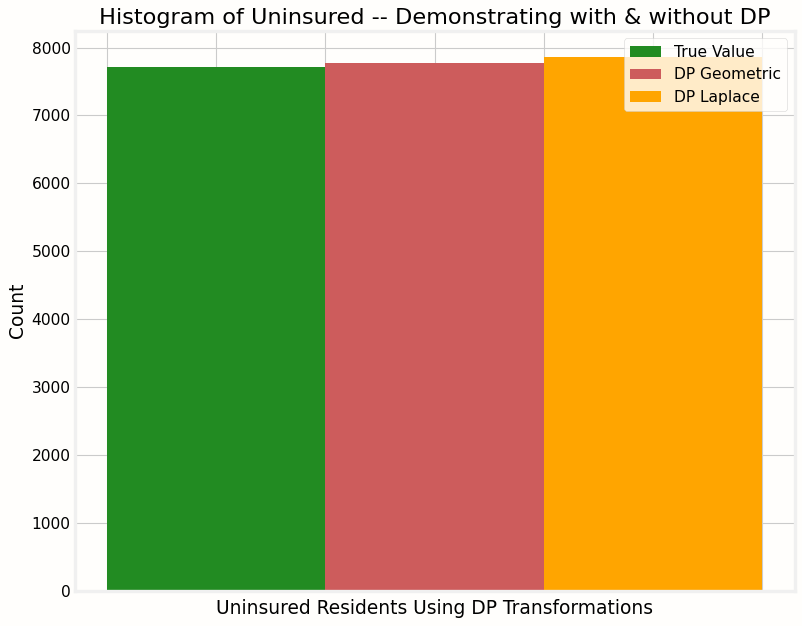

In [7]:
colorseq = ["forestgreen", "indianred", "orange"]
fig = plt.figure(figsize=(9, 7), dpi=80)
fig.patch.set_facecolor(COLOR)
ax = fig.add_axes([0,0,1,1])
insuranceCat = [0]
width = 0.1
insuranceCat_left = [x + width for x in insuranceCat]
insuranceCat_right = [x + 2*width for x in insuranceCat]
ax.bar(insuranceCat, df.INSURANCE_COVERAGE.value_counts().values[1], width=width, color=colorseq[0], label='True Value')
ax.bar(insuranceCat_left, insurance_histogram.value[1], width=width, color=colorseq[1], label='DP Geometric')
ax.bar(insuranceCat_right, insurance_histogram2.value[1], width=width, color=colorseq[2], label='DP Laplace')
ax.set_xticklabels([])
ax.legend()
plt.title('Histogram of Uninsured -- Demonstrating with & without DP')
plt.ylabel('Count')
plt.xlabel("Uninsured Residents Using DP Transformations")
plt.show()

<a id='missing'></a>
### 3B. Missing Data

With roughly 270 columns in the dataset and considering that census data is survey data that is reliant on
users answering questions, it is important to identify columns with missing values and develop a strategy for
dealing with these missing values, whether that be removal of the variable all together, removal of specific
rows, or imputation of some sort. The below chart displays the worst offenders of missing values in the MA census
data as a percent of rows where that value is missing. Some of these columns have greater than 50% of the
data missing. In these drastic cases it is reasonable to throw these predictors out all together considering the
vast number of predictor columns in the dataset that have much more data. In cases where less than 20% of
the data is missing it may make more sense to try and impute the values likely with the median.

[Back to Top](#top)

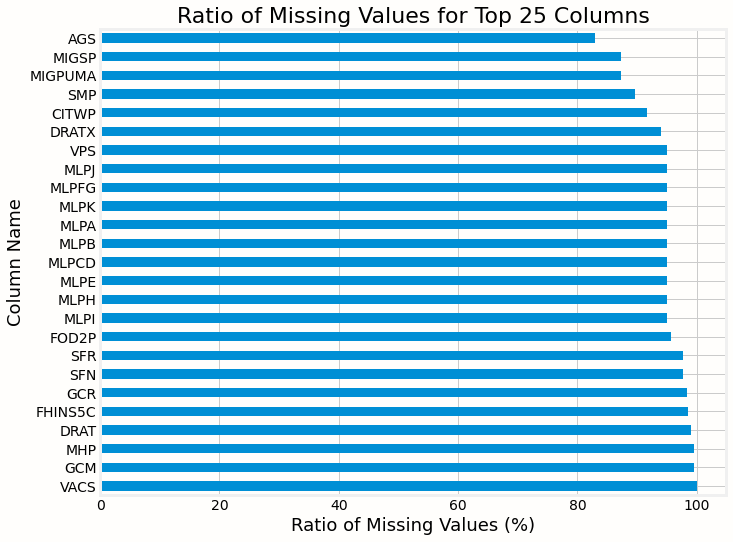

In [9]:
# code for missing columns
def plot_nas(df: pd.DataFrame, top_x = 25):
    if df.isnull().sum().sum() != 0:
        
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        fig, ax = plt.subplots(facecolor=COLOR)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df[:top_x]})
        missing_data.plot(kind = "barh", ax=ax, legend=None)
        ax.set_facecolor(COLOR)
        plt.rcParams['figure.figsize'] = [10, 8]
        plt.title(f"Ratio of Missing Values for Top {top_x} Columns", fontsize=22)
        plt.ylabel("Column Name", size=18)
        plt.xlabel("Ratio of Missing Values (%)", size=18)
        plt.show() 
    else:
        print('No NAs found')
        
plot_nas(df, top_x=25)

<a id='multico'></a>
### 3C. Multicollinearity

With the high number of columns in the dataset, it is evident that many
columns will be redundant. One way to identify this simply is to look at
the correlation between the predictor variables. Identifying this in the
early EDA of this project is important so that a strategy for reducing the
dimensions of the dataset can be determined. Some features may be
removed simply from looking at correlation values such as what can be
seen in the below table, but due to the high number of features, it will be likely
that some sort of Principal Component Analysis will be run on the data
prior to modeling, to reduce the number of dimensions in the dataset.

Another visualization that would have nicely captured these relationships would have been a correlation plot, however with the high number of features in the dataset this proved to be inefficient and not a useful visualization.

[Back to Top](#top)


In [10]:
# code for demonstrating high multicolinerarity
correlated_vars = df.corr().unstack().sort_values(ascending = False).drop_duplicates()
correlated_vars = correlated_vars.to_frame()
sliced_df = correlated_vars.head(5)
sliced_df = sliced_df.append(correlated_vars.tail(5))
sliced_df.drop(sliced_df.tail(1).index,inplace=True) # drop last n rows
sliced_df.drop(sliced_df.head(1).index,inplace=True) # drop first n rows
sliced_df.rename(columns = {0:'Correlation'}, inplace = True)
sliced_df

Correlation
FOTHSVCEXP FDIALUPP     0.999330
ADJHSG     ADJINC_P     0.996163
MAR        MSP          0.993576
RAC1P      RAC2P        0.990523
R18        FPARC       -0.911545
           HUPARC      -0.913537
           HUPAC       -0.922271
WKW        WKWN        -0.978506

<a id='processing'></a>

## 4. Pre-processing

As demonstrated in the EDA section of the report there are many issues with the dataset which is not entirely unexpected as we are dealing with incomplete census data. The pre-processing section will describe the team's methodology for handling some of these issues.

<a id='object'></a>

### 4A. Removing Non-Int Columns

Because of the vast number of columns in the dataset, we didn't hold back much heartache removing some of the non-integer columns as there were just 4 of them in the dataset. One hot encoding is always an option with categorical data however increasing the dimensionality at this time didn't justify the move for just these columns, so they will be dropped from the dataset for now.

[Back to Top](#top)

In [11]:
processed_df = df.select_dtypes(exclude=['object'])


<a id='handmissing'></a>

### 4B. Handling Majority Missing Data Columns

Next, we will drop some numeric columns as well, this time for the purpose of dealing with missing data in this dataset. As we saw in part 3B, we have what appears to be an overwhelming number of missing values.  Normally, it would be convenient to simply use dropna, but in this case every row has at least one missing column so this is simply not feasible.  The first step we can take to resolve the missing data problem is to go for the low hanging fruit - we can drop columns that do not meet a specific threshold ratio of non-NaN values.  Initially we removed columns that are 50% or above NaN, but upon further inspection it seems like since the dimensionality of this dataset is so astronomically large, we should be allowed to be stricter and therefore remove columns that have 25% or higher missing values.

[Back to Top](#top)



Number of rows with missing values before removing columns:  335410
Number of columns before removal: 505
Number of rows with missing values after removing columns:  111244
Number of columns after removal:  420


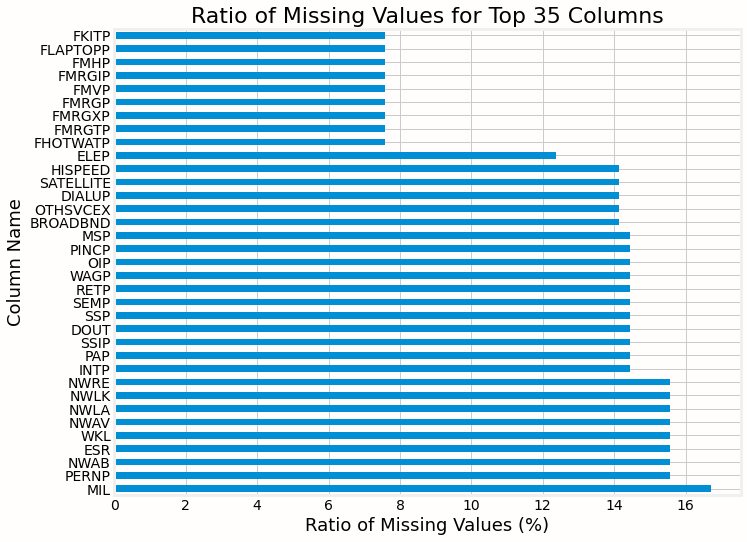

In [12]:
print("Number of rows with missing values before removing columns: ", df.shape[0] - df.dropna().shape[0])
print(f"Number of columns before removal: {len(processed_df.columns)}")
# remove columns that are > 25%  Nan
processed_df.dropna(thresh=len(processed_df.index)*.75, axis=1, inplace=True)

print("Number of rows with missing values after removing columns: ", processed_df.shape[0] - processed_df.dropna().shape[0])
print("Number of columns after removal: ", len(processed_df.columns))

plot_nas(processed_df, top_x=35)

This is a good start, but we can see that we still have many 111244 rows with at least one NaN.  Again it is tempting to simply drop these rows.  However this would leave us a small fraction of the original dataset we were given, and this may not be a good representation of the original data.  Furthermore, we do not know if there is a correlation between the predictors and which rows/columns have missing data which could bias our results.

Therefore we will have to look into ways of imputing data to fill in the missing column values.   But first, we will split the data into our training and test datasets, in order to make sure that any changes on the training dataset are NOT influenced by the test dataset

<a id='tts'></a>
### 4C. Train Test Split

Prior to imputation we will split the data into training and testing as to only impute on the testing set with what was seen in the training set. This is a small but important step in ensuring no data leaks from our training set into our testing datasets. Or in this case information from our testing set into our training set!

[Back to Top](#top)

In [13]:
train_df, test_df = train_test_split(processed_df, test_size=0.3) 

<a id='imputation'></a>
### 4D. Imputation
A few approaches were attempted for imputation. The team had identified KNN imputation as a great option. For this dataset, it is a reasonable assumption that a point value can be approximated by the values of points with similar column values, especially given the high multicollinearity revealed in our initial exploratory data analysis. Unfortunately, on the large scale of the dataset KNNImpute was taking much too long to be used in an iterative way, and if we made any mistakes or needed to adjust the final processed dataset it was proving cumbersome to compute. For those reasons we have simply gone with a simple mean imputation strategy. 

[Back to Top](#top)


In [14]:
# imputing with the mean
mean_imputer = SimpleImputer(strategy='mean')
mean_imputer.fit(train_df)
pd.DataFrame(mean_imputer.transform(train_df), columns=train_df.columns).to_csv("data/imputed_train_data.csv", index=False)
pd.DataFrame(mean_imputer.transform(test_df), columns=test_df.columns).to_csv("data/imputed_test_data.csv", index=False)

<a id='smote'></a>
### 4E. Handling Class Imbalance (SMOTE)

Next, let's analyze how we can address the class imbalance problem in the dataset. There were two main ideas that were discussed for this:

1. Changing Class Weights
2. SMOTE

#### Changing Class Weights

Changing class weights is an argument in sklearn's models where the user defines how important each class is, for example a user may input `class_weights = {0:0.8, 1: 0.2}` indicating that class `0` will be weighted at 80% and class `1` will be weighted at 20%. This likely would have been a good method to try in the modeling however, due to using the differential privacy LogisticRegression class, this weighting is actually not available in the subclass -- so without a lot of extra work this method is a bit unreasonable to try given our constraints.

### SMOTE

SMOTE is a Synthetic Minority Oversampling Technique used to oversample the underrepresented class in imbalanced datasets. In this example SMOTE will be used to oversample the uninsured residents in the state of Massachusetts. Models will be tried both using SMOTE and not using SMOTE to see if SMOTE has an effect on the model performance.

First, let's read in the data that we produced from the preprocessing step and visualize how SMOTE changes our dataset.

[Back to Top](#top)



In [15]:
# Read in data saved after imputing process
df_train = pd.read_csv("data/imputed_train_data.csv")
df_test = pd.read_csv("data/imputed_test_data.csv")

# Get X and y data from df_train
train_cols = [col for col in df_train.columns.tolist() if col not in ["INSURANCE_COVERAGE"]]
X_train = df_train[train_cols]
y_train = df_train.INSURANCE_COVERAGE

# get X and y data for df_test
X_test = df_test[train_cols]
y_test = df_test.INSURANCE_COVERAGE

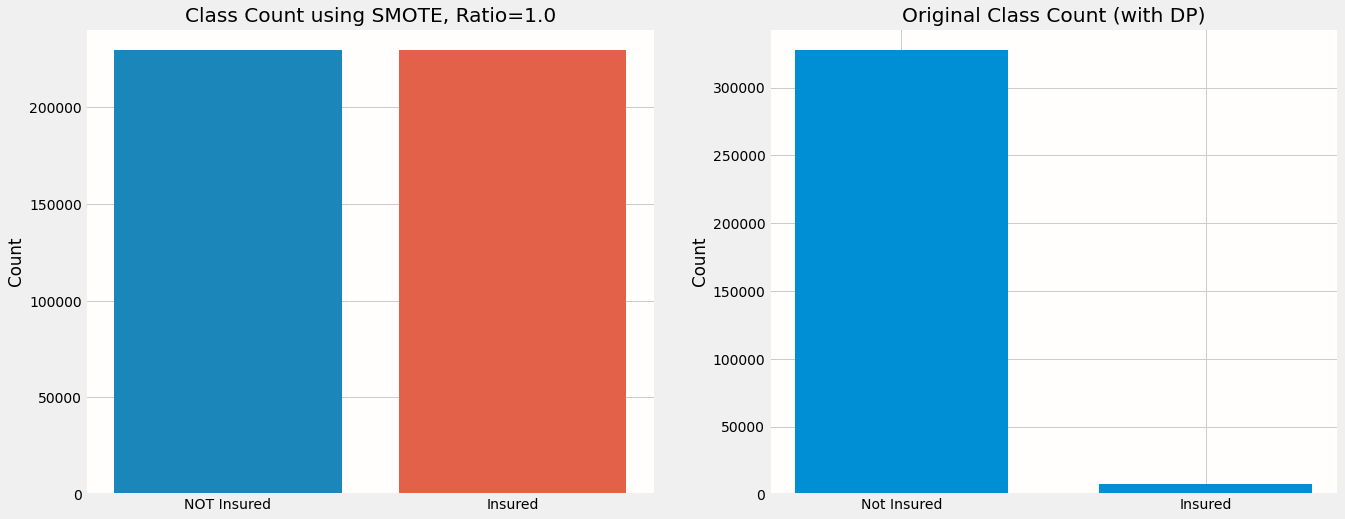

In [16]:
# oversample with SMOTE
oversample = SMOTE(random_state=109)
X_train_oversample, y_train_oversample = oversample.fit_resample(X_train, y_train)

# common sytle would be good to have 
plt.rcParams["figure.figsize"] = (20,8)

# plot class imblance with SMOTE
plt.subplot(1, 2, 1) # row 1, col 2 index 1
g = sns.countplot(y_train_oversample)
g.set_xticklabels(['NOT Insured','Insured'])
plt.title("Class Count using SMOTE, Ratio=1.0")
plt.xlabel('')
plt.ylabel('Count')

# plot class imblance before SMOTE
with sn.Analysis(protect_floating_point=False) as anyalysis:  
    
    # laplace method
    insurance_prep = sn.histogram(sn.to_bool(df['INSURANCE_COVERAGE'], true_label=0), null_value = True)
    insurance_histogram2 = sn.laplace_mechanism(insurance_prep, privacy_usage={"epsilon": 0.009, "delta": .000001})

anyalysis.release()

plt.subplot(1, 2, 2) # index 2
plt.bar(["Not Insured", "Insured"], insurance_histogram2.value.tolist(),
        width = 0.7)
plt.title("Original Class Count (with DP)")
plt.xlabel('')
plt.ylabel('Count')
plt.show()

<a id='pca'></a>

### 4F. Principal Component Analysis (PCA)

PCA was also identified as one method to handle dealing with the high dimensionality in the dataset. No preprocessing code is shown for PCA as it will be applied directly to the sklearn pipelines. PCA should attempt to help resolve both our problems at once, because we can flatten our high dimensionality to a small number of vectors of our choosing.  This can also help to eliminate redundancies and multicollinearity.


<a id='moedeling'></a>

## 5. Modeling

This section will describe our approach to modeling as well as some of the constraints and metric decisions that were used. Many examples will be shown, as well as a summary table of all the attempted models, and their scores.

<a id='metrics'></a>

### 5A. Metrics

In highly imbalanced datasets choosing metrics that can be useful to evaluation are extremely important. In our dataset case if we were to simply predict `insured` for every resident we would achieve an accuracy of 97% which would mislead someone to believe our model accurately predicts users who are uninsured when in fact it can't predict that at all. Because of this, metrics such as Precision and Recall give a much better understanding for how well our model is predicting on the positive label (or in our case 0 which represents uninsured residents). Recall describes how many of the uninsured users we are predicting correctly, i.e. a Recall of 90% would mean that our model found 90/100 uninsured residents (a quite useful metric for our case). Precision tells us how often when our model predicts the positive class that our model found the user to actually be uninsured. A precision of 90% would tell us that 90/100 uninsured predictions were correct, and that we predicted 10 people to be uninsured who were in fact insured. You will see in the modeling below the challenges between these two metrics. In a perfect world you would want high precision and high recall, however in reality there is a tradeoff in the majority of models. What becomes most important in the end is what the end user prefers for the Data Scientists to optimize on -- more on this in the conclusion of the paper.

<a id='approach'></a>

### 5B. Approach

To hit our goals of detecting uninsured residents and retaining differential privacy, we tried logistic regression and random forest models of various parameter configurations.  We concluded that logistic regression and random forest would be best suited for binary classification as well as providing model interpretability that would be useful for the State of Massachusetts. Below is an outline of how we approached constructing our binary classification models:

1. Use models with DP & without DP to compare results
2. Try many models 
3. Grid Search to optimize notable params
4. Extract Feature Importances out of LogReg Models to compare DP and non DP models
5. Use sklearn's pipeline functionality to take advantage of trying different modeling techniques quickly and easily

<a id='constrains'></a>

### 5C. DP In Modeling

To implement DP in our modeling we are using the classes from the diffpriv library. This is noteworthy because for the purposes of this project we will be limited to the out of the box algorithms that work with this DP library. Under the hood of the algorithm randomness is thrown into the data to preserve privacy, therefore no two DP models will be the same! Note that in some of the output plots we also take DP into account (see the helper function where we create the confusion matrix). 


[Back to Top](#top)



In [17]:
# HELPERS!
def apply_dp(value):
    return int(sn.LibraryWrapper().laplace_mechanism(value, epsilon=0.5, sensitivity=5, enforce_constant_time=False))

def pr_curve(precision, recall, name = None, save_fig = False):

    fig = figure(figsize=(10, 6), dpi=80)
    fig.patch.set_facecolor(COLOR)
    plt.plot(recall, precision)
    plt.rcParams['axes.facecolor'] = COLOR
    plt.xlabel("Recall", size=18)
    plt.ylabel("Precision", size=18)
    plt.title(f"Precision/Recall - {name}")
    
    if save_fig:
        if name is None:
            print('You need to have name specified to save Figure')
        else:
            plt.savefig(f'{name}.png')
    
    plt.show()
    
def conf_mat(y_test, preds, name=None, save_fig=False):
    cm = confusion_matrix(y_test, preds, positive_label=0)
    
    # ADD DP INTO CONFUSTION MATRIX
    vfunc = np.vectorize(apply_dp)
    result = vfunc(cm)
    
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(8,8))
    fig.patch.set_facecolor(COLOR)
    plt.rcParams['axes.facecolor'] = COLOR
    plt.xlabel("Predicted Label", size=18)
    plt.ylabel("True Label", size=18)
    plt.title(f"Confusion Matrix - {name} -- WITH DP!")
    
    if save_fig:
        if name is None:
            print('You need to have name specified to save Figure')
        else:
            plt.savefig(f'{name}.png')
            
    plt.show()
    
def plot_pca_logreg_feature_importance(pipe, name):
    # number of components
    n_pcs= pipe["pca"].components_.shape[0]

    # get the index of the most important feature on EACH component
    most_important = [np.abs(pipe["pca"].components_[i]).argmax() for i in range(n_pcs)]

    # list of the original features
    initial_feature_names = pipe.feature_names_in_

    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    most_important_names = [f"PCA{idx}_{name}" for idx, name in enumerate(most_important_names)]

    # get log reg coefs
    importance = pipe['logistic'].coef_[0]

    # sort the two lists in the same way for plotting purposes
    most_important_names_sorted = [x for _, x in sorted(zip(importance, most_important_names))]
    importance_sorted = np.sort(importance)

    # summarize feature importance
    # negative features are the ones that help predict class 0!
    fig, ax = plt.subplots(1, 1, figsize=(25, 9))
    fig.patch.set_facecolor(COLOR)
    sns.barplot(x=most_important_names_sorted, y=importance_sorted, color='#4682B4')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=9)
    ax.set_title(f"Logistic Regression/PCA Feature Importances - {name}", fontsize=25)
    ax.set_ylabel("Coef", fontsize=18)
    ax.set_xlabel("PCA Feature Name", fontsize=18)
    plt.show()

<a id='logreg'></a>


### 5D. Logistic Regression

#### Logistic Regression Baseline (No Grid Search, No SMOTE) (PCA & Scaling Included)

First to get started let's just try a simple Logistic Regression model with standard scaling and pca using `n_compoents of 25`. Note that the confusion matrices have DP applied to them! See the helper functions above!

[Back to Top](#top)



F1 SCORE: 0.07754601226993865
ACCURACY: 0.9626427357562386
RECALL OF UNINSURED: 0.0676949443016281
PRECISION OF UNINSURED: 0.09075244112578977


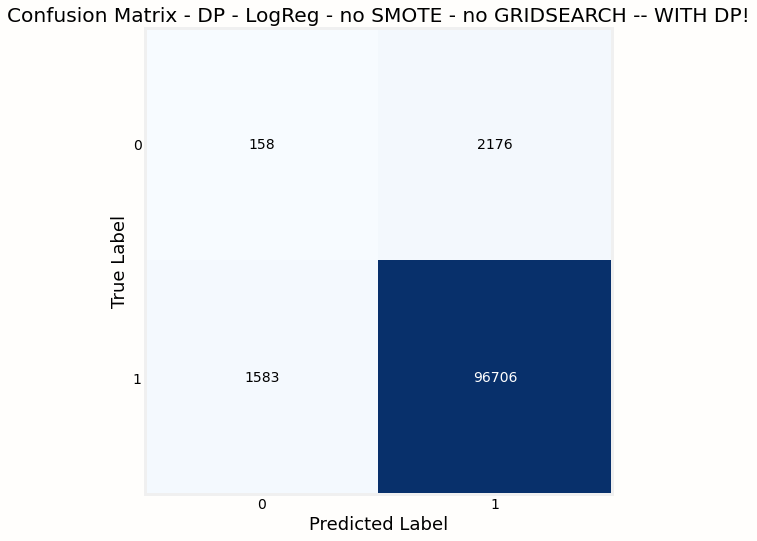

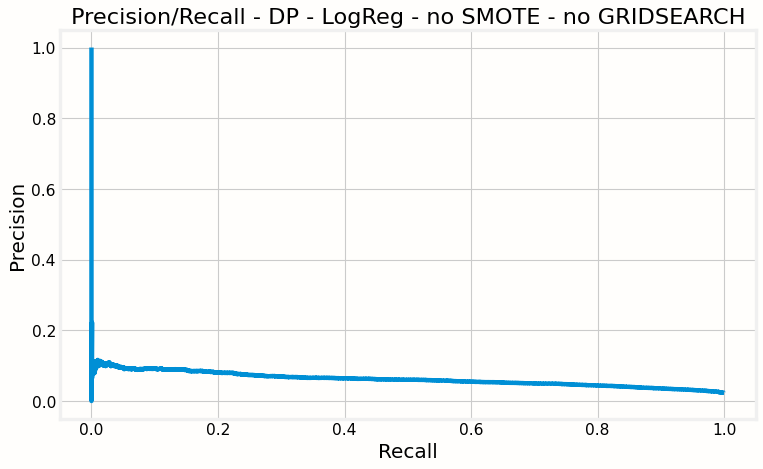

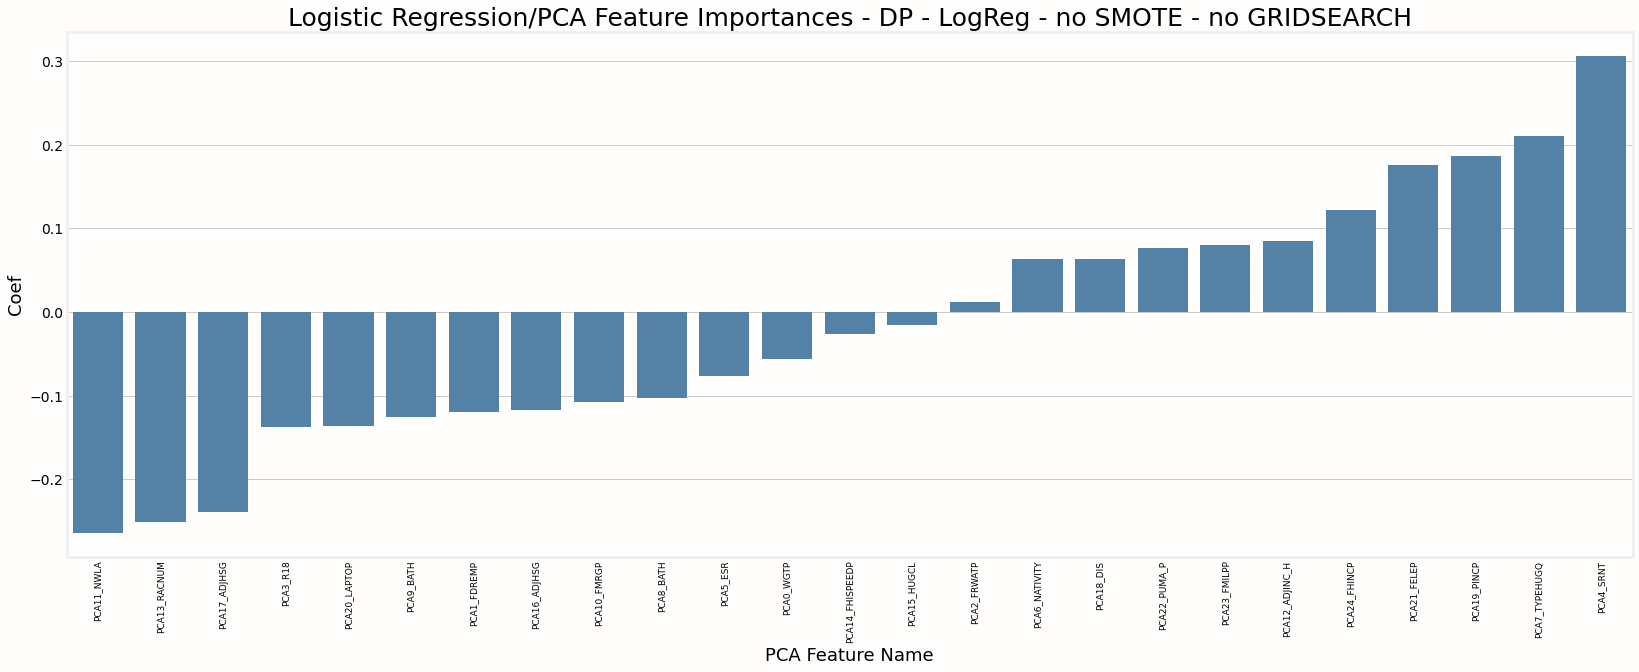

In [18]:
# and classifier regularization.
pca = PCA(random_state=109, n_components=25)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# model
logistic = LogisticRegression(max_iter=10000, epsilon=3.0, data_norm=7.89)

# create a pipeline
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("logistic", logistic)])

# fit model
pipe.fit(X_train, y_train)

# predict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

# print accuracy score
model1_acc = accuracy_score(y_test, preds)
model1_recall = recall_score(y_test, preds, pos_label=0)
model1_prec = precision_score(y_test, preds, pos_label=0)
model1_f1 = f1_score(y_test, preds, pos_label=0)
print(f"F1 SCORE: {model1_f1}")
print(f"ACCURACY: {model1_acc}")
print(f"RECALL OF UNINSURED: {model1_recall}")
print(f"PRECISION OF UNINSURED: {model1_prec}")

model1 = "DP - LogReg - no SMOTE - no GRIDSEARCH"

# plot confusion matrix
conf_mat(y_test, preds, name= model1)

# get just class 0 and get pr 
y_scores = [x[0] for x in preds_proba]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=0)

# plot PR curve
pr_curve(precision, recall, name = model1)

# plot log reg pca importance
plot_pca_logreg_feature_importance(pipe, name = model1)

#### Baseline logistic regression model without DP 

We used the same parameters to train a logistic regression with basic sklearn implementations to compare the impact of the noises added by Differential Privacy.

[Back to Top](#top)


F1 SCORE: 0.0
ACCURACY: 0.9768045079156853
RECALL OF UNINSURED: 0.0
PRECISION OF UNINSURED: 0.0


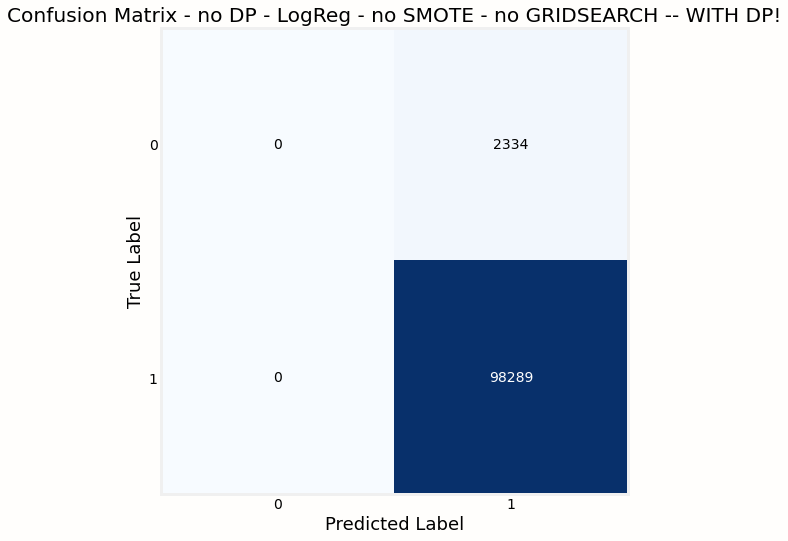

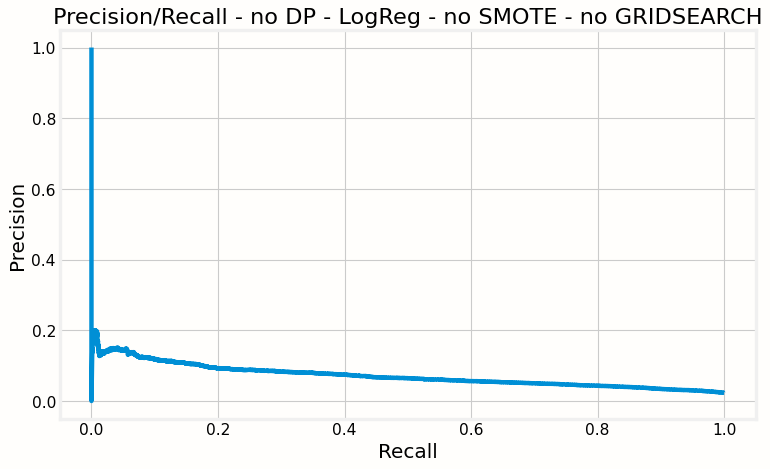

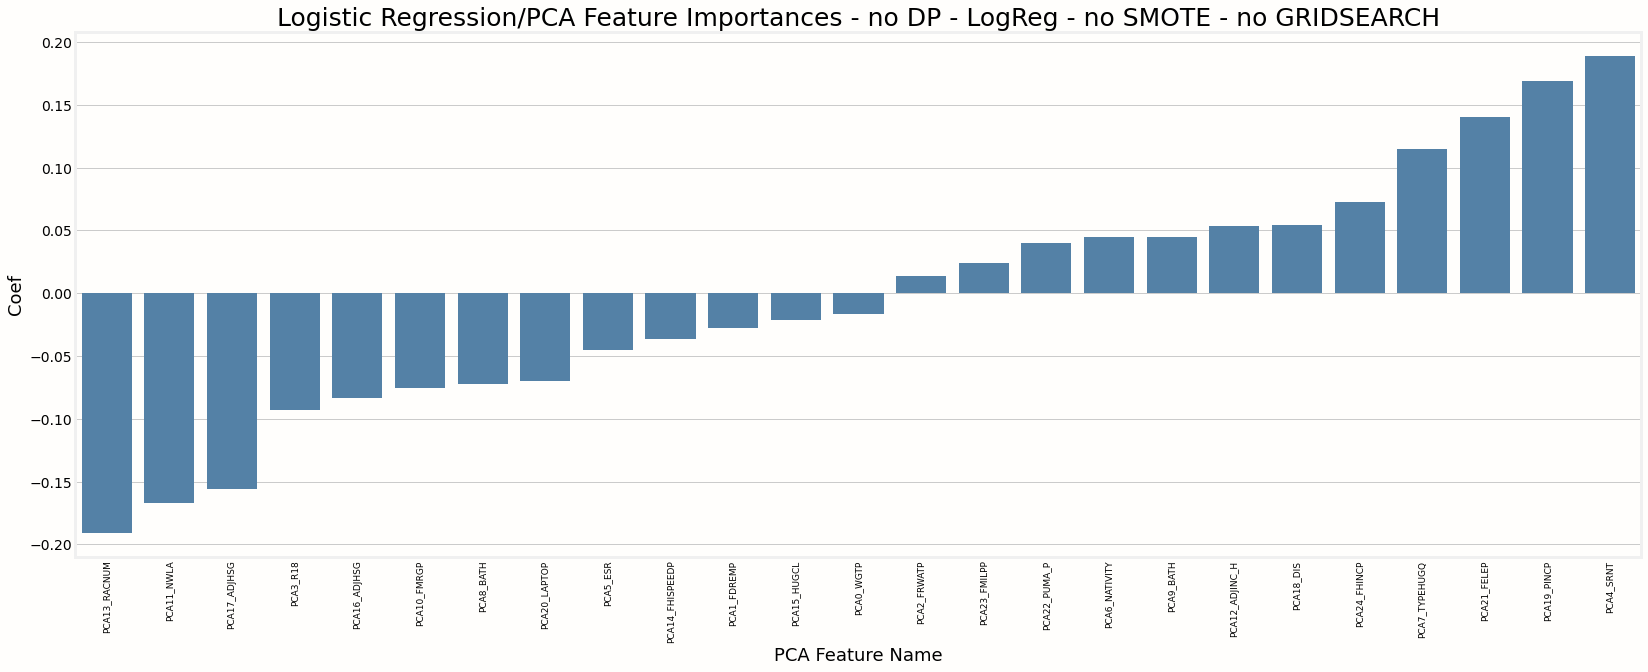

In [19]:
# and classifier regularization.
pca = PCA(random_state=109, n_components=25)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# model
logistic = SKLearnLogsiticRegression(max_iter=10000)

# create a pipeline
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("logistic", logistic)])

# fit model
pipe.fit(X_train, y_train)

# predict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

# print accuracy score
skmodel1_acc = accuracy_score(y_test, preds)
skmodel1_recall = recall_score(y_test, preds, pos_label=0)
skmodel1_prec = precision_score(y_test, preds, pos_label=0)
skmodel1_f1 = f1_score(y_test, preds, pos_label=0)
print(f"F1 SCORE: {skmodel1_f1}")
print(f"ACCURACY: {skmodel1_acc}")
print(f"RECALL OF UNINSURED: {skmodel1_recall}")
print(f"PRECISION OF UNINSURED: {skmodel1_prec}")

skmodel1 = "no DP - LogReg - no SMOTE - no GRIDSEARCH"

# plot confusion matrix
conf_mat(y_test, preds, name= skmodel1)

# get just class 0 and get pr 
y_scores = [x[0] for x in preds_proba]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=0)

# plot PR curve
pr_curve(precision, recall, name = skmodel1)

# plot log reg pca importance
plot_pca_logreg_feature_importance(pipe, name = skmodel1)

As can be seen from the results above, the basic sklearn model performs even worse on the precision and recall score as it only learns to predict that a person has insurance. It was not able to identify a true negative. 

#### Grid Search

It was identified that although we were able to achieve some fairly decent recall scores, the amount of false positives was extremely high. A gridsearch was run with more parameters to optimize on including the ratio of upsampling that SMOTE would produce. This gridsearch was able to increase the precision in some cases, but at a drastic loss in the recall after further investigation. This code took much too long to keep in the final notebook, but here is an example of the cross validation outputs that were generated while running this notebook in colab. This search was also performed which attempted to optimize on the F1 Score (instead of precision/recall) as we wanted to find the optimized value between the two metrics. This resulted in the following output for parameters in the model, with the score being the F1 Score. Accuracy was not considered for the gridsearch considering the high class imbalance made this metric not very useful.

```
Best parameter (CV score=0.133):
{'logistic__C': 0.0001, 'pca__n_components': 120, 'smote__k_neighbors': 6, 'smote__sampling_strategy': 0.33}
```

#### Logistic Regression Post GridSearchCV without SMOTE

Using the params from the optimized grid search on F1 score lets see how the model performs when testing on the testing dataset. Although the model above was optimized with SMOTE, just for comparison lets first try this model WITHOUT SMOTE.

[Back to Top](#top)



F1 SCORE: 0.033003300330033
ACCURACY: 0.9737932679407293
RECALL OF UNINSURED: 0.019280205655526992
PRECISION OF UNINSURED: 0.11450381679389313


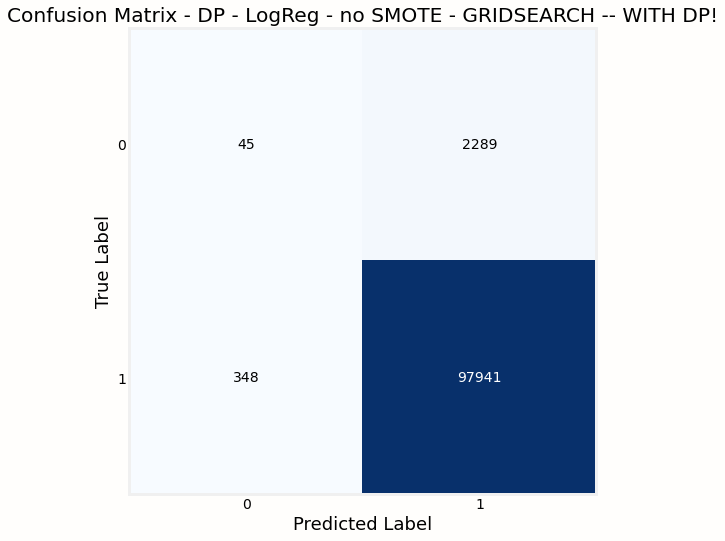

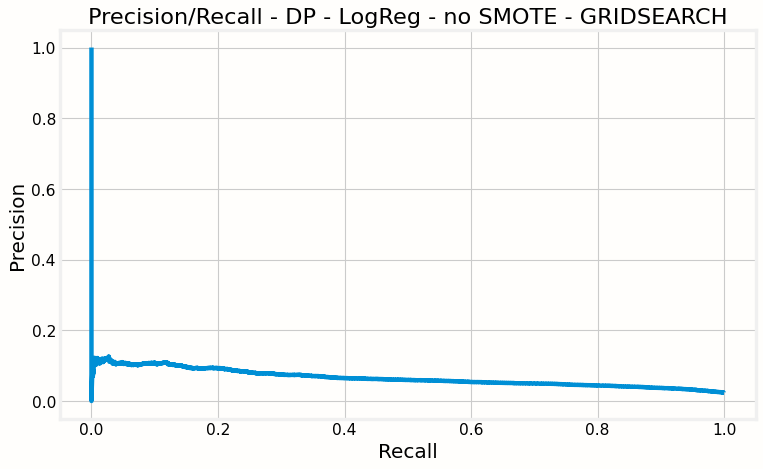

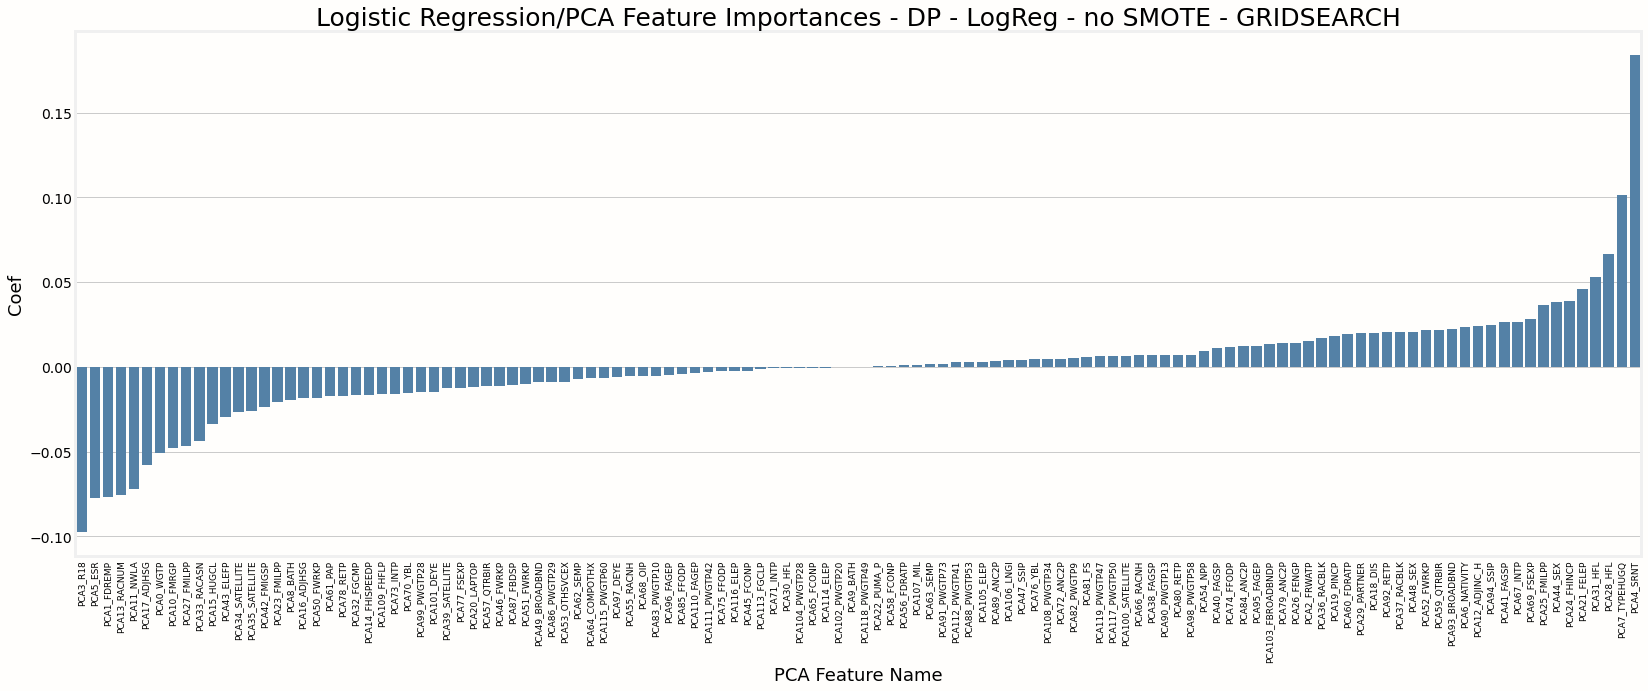

In [20]:
# and classifier regularization.
pca = PCA(random_state=109, n_components=120)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

#model
logistic = LogisticRegression(max_iter=10000, tol=0.0001, C=0.0001, epsilon=3.0, data_norm=7.89)

# create a pipeline
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("logistic", logistic)])

# fit model
pipe.fit(X_train, y_train)

# predict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

# print accuracy score
model2_acc = accuracy_score(y_test, preds)
model2_recall = recall_score(y_test, preds, pos_label=0)
model2_prec = precision_score(y_test, preds, pos_label=0)
model2_f1 = f1_score(y_test, preds, pos_label=0)
print(f"F1 SCORE: {model2_f1}")
print(f"ACCURACY: {model2_acc}")
print(f"RECALL OF UNINSURED: {model2_recall}")
print(f"PRECISION OF UNINSURED: {model2_prec}")

model2 = "DP - LogReg - no SMOTE - GRIDSEARCH"

# plot confusion matrix
conf_mat(y_test, preds, name= model2)

# get just class 0 and get pr 
y_scores = [x[0] for x in preds_proba]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=0)

# plot PR curve
pr_curve(precision, recall, name = model2)

# plot log reg pca importance
plot_pca_logreg_feature_importance(pipe, name = model2)

A recall of just 10% still proves to be poor performance, lets see if we can improve this with SMOTE.

#### Logistic Regression Post GridSearchCV with SMOTE

From the results below we see that our recall does much better then the model without SMOTE (at 73%) however this is because our model is predicting the uninsured class at a much higher rate leading to a very low precision of just 5%.

[Back to Top](#top)

F1 SCORE: 0.12128639648396228
ACCURACY: 0.7933573835007901
RECALL OF UNINSURED: 0.6148243359040274
PRECISION OF UNINSURED: 0.0672792911060059


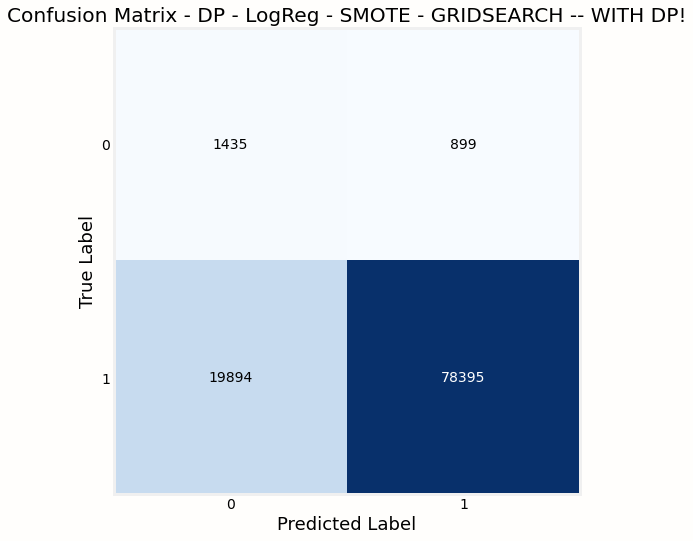

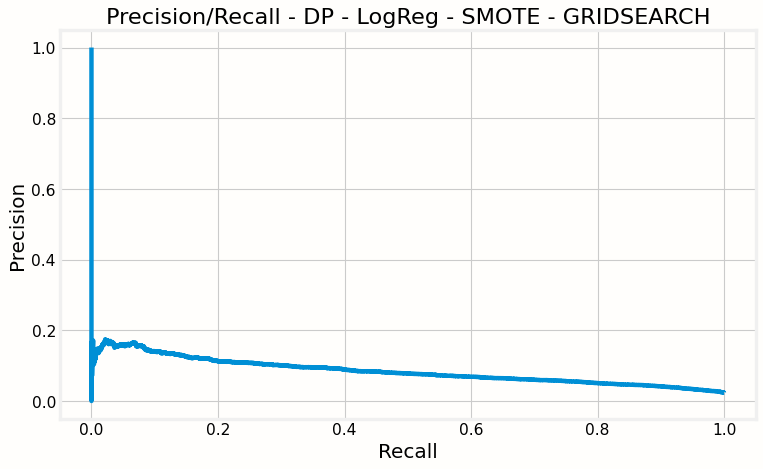

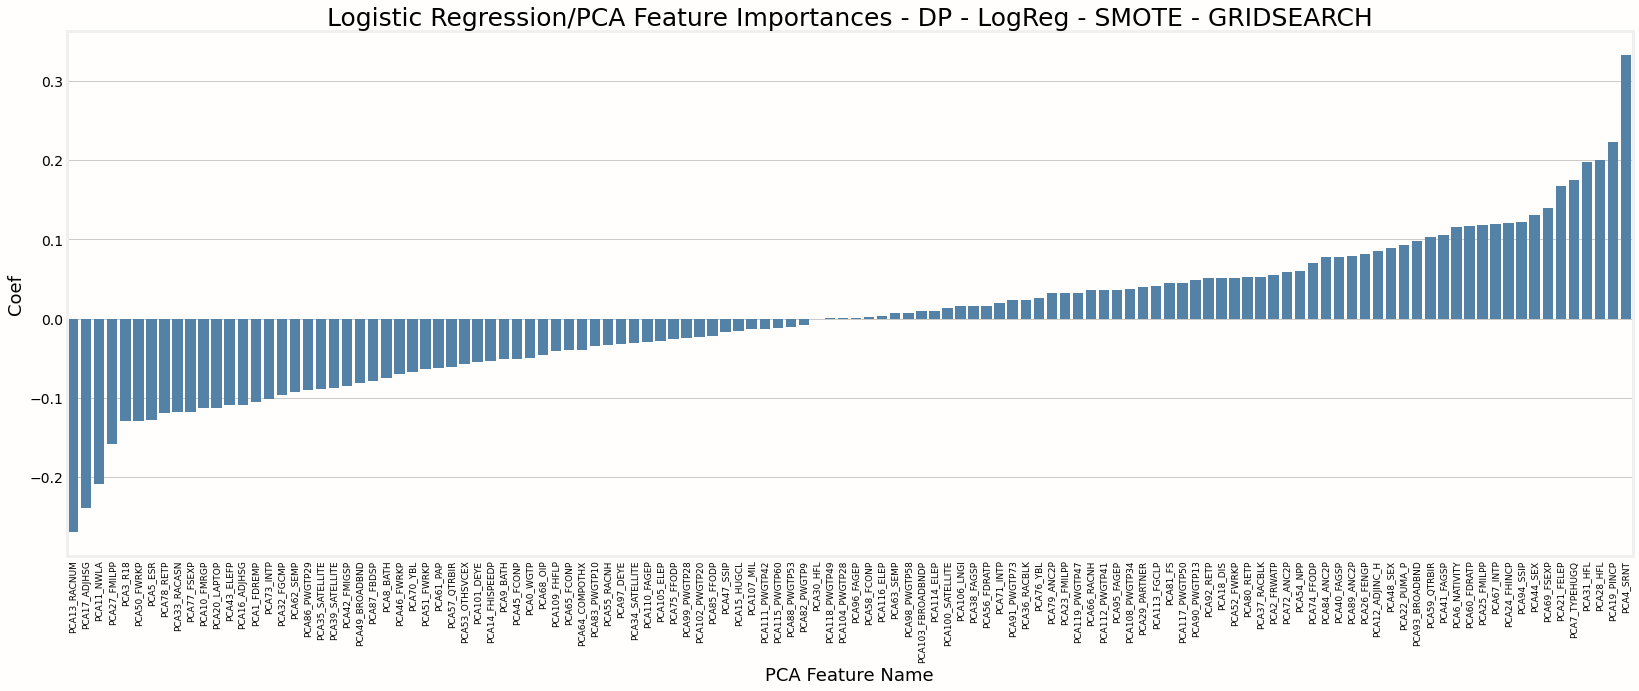

In [21]:
# add smote
smote = SMOTE(random_state = 109, k_neighbors=6, sampling_strategy=0.33)

# create a pipeline with SMOTE, class weight even
logistic = LogisticRegression(max_iter=10000, tol=0.001, C=0.0001, epsilon=3.0, data_norm=7.89)

# create pipeline
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("smote", smote), ("logistic", logistic)])

# fit model
pipe.fit(X_train, y_train)

# predict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

# print accuracy score
model3_acc = accuracy_score(y_test, preds)
model3_recall = recall_score(y_test, preds, pos_label=0)
model3_prec = precision_score(y_test, preds, pos_label=0)
model3_f1 = f1_score(y_test, preds, pos_label=0)
print(f"F1 SCORE: {model3_f1}")
print(f"ACCURACY: {model3_acc}")
print(f"RECALL OF UNINSURED: {model3_recall}")
print(f"PRECISION OF UNINSURED: {model3_prec}")

model3 = "DP - LogReg - SMOTE - GRIDSEARCH"

# plot confusion matrix
conf_mat(y_test, preds, name= model3)

# get just class 0 and get pr 
y_scores = [x[0] for x in preds_proba]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=0)

# plot PR curve
pr_curve(precision, recall, name = model3)

# plot log reg pca importance
plot_pca_logreg_feature_importance(pipe, name = model3)

#### SKlearn Logistic Regression Post GridSearchCV with SMOTE

From below, we used the parameters we found in grid search CV to apply a simple sklearn model with no DP. The performance was not better than one with DP package built in

[Back to Top](#top)


F1 SCORE: 0.16615732880588568
ACCURACY: 0.9267861224570924
RECALL OF UNINSURED: 0.3144815766923736
PRECISION OF UNINSURED: 0.11290570681433626


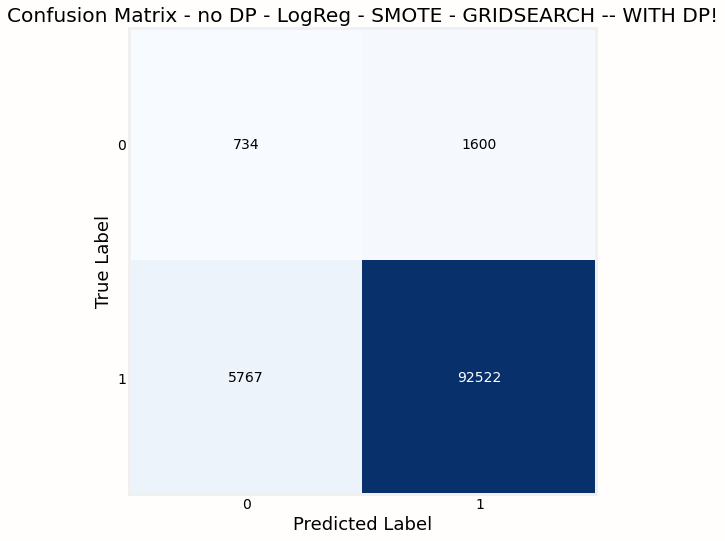

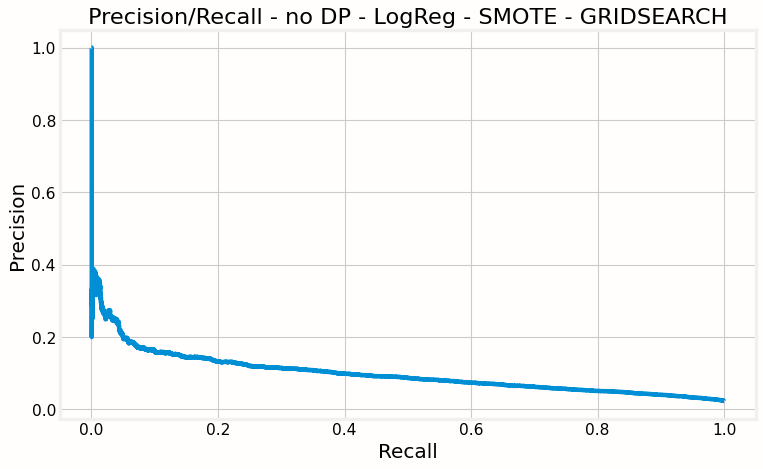

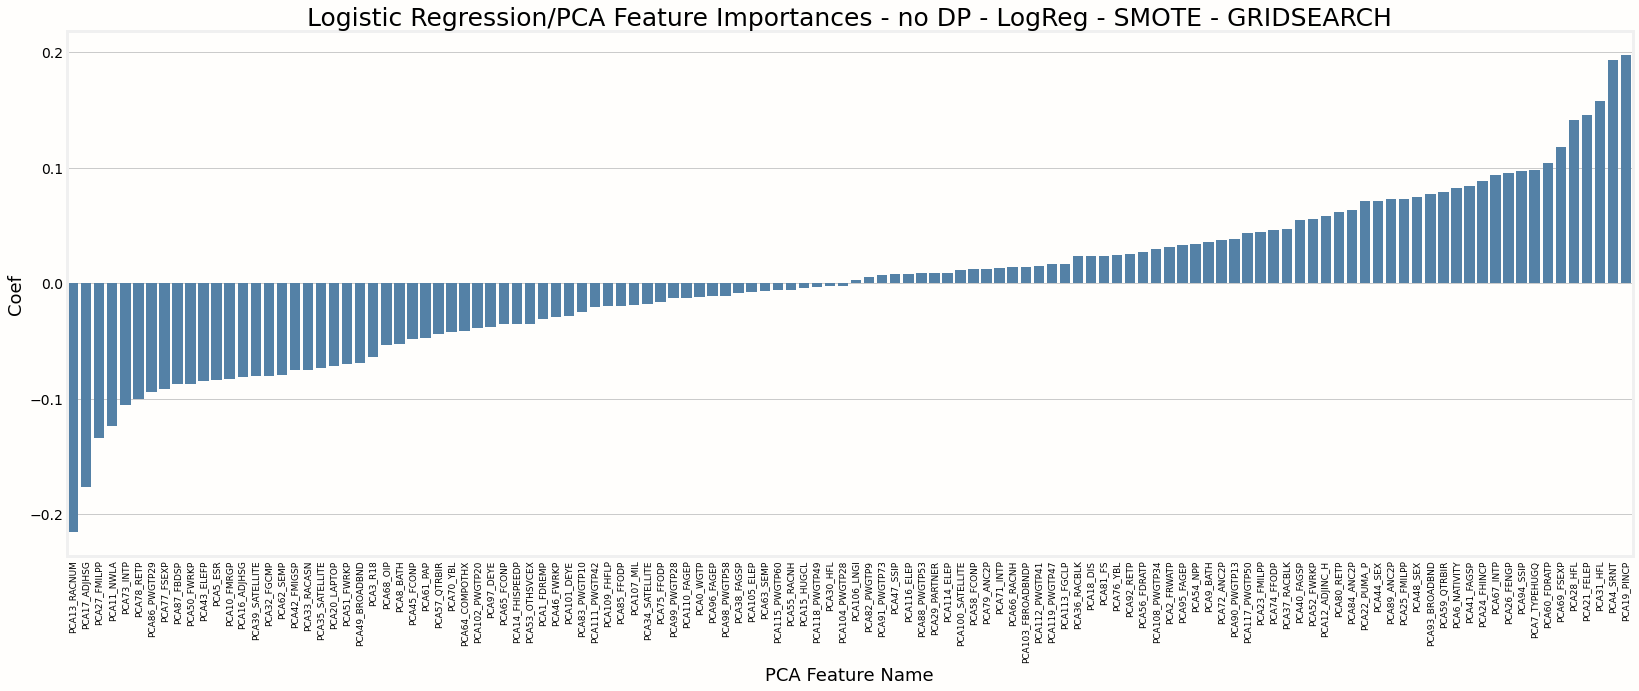

In [22]:
smote = SMOTE(random_state = 109, k_neighbors=6, sampling_strategy=0.33)

# create a pipeline with SMOTE, class weight even
logistic = SKLearnLogsiticRegression(max_iter=10000, tol=0.001, C=0.0001)

# create pipeline
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("smote", smote), ("logistic", logistic)])

# fit model
pipe.fit(X_train, y_train)

# predict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

# print accuracy score
skmodel2_acc = accuracy_score(y_test, preds)
skmodel2_recall = recall_score(y_test, preds, pos_label=0)
skmodel2_prec = precision_score(y_test, preds, pos_label=0)
skmodel2_f1 = f1_score(y_test, preds, pos_label=0)
print(f"F1 SCORE: {skmodel2_f1}")
print(f"ACCURACY: {skmodel2_acc}")
print(f"RECALL OF UNINSURED: {skmodel2_recall}")
print(f"PRECISION OF UNINSURED: {skmodel2_prec}")

skmodel2 = "no DP - LogReg - SMOTE - GRIDSEARCH"

# plot confusion matrix
conf_mat(y_test, preds, name= skmodel2)

# get just class 0 and get pr 
y_scores = [x[0] for x in preds_proba]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=0)

# plot PR curve
pr_curve(precision, recall, name = skmodel2)

# plot log reg pca importance
plot_pca_logreg_feature_importance(pipe, name = skmodel2)

As we can see, with SMOTE and the parameter searched by the grid search, the sklearn model performed better than baseline but still not out-performing the DP model. 

<a id='rf'></a>

### 5E. Random Forest 

Although the vast amount of modeling time was spent trying to achieve some worthwhile results out of the logistic regression model, random forest was also attempted.

#### Random Forest Pre GridSearch (without SMOTE)

First let's try the model without SMOTE -- From the below results our model is only predicting residents to be insured leading to a precision and recall of 0.

[Back to Top](#top)


F1 SCORE: 0.0
ACCURACY: 0.9767945698299594
RECALL OF UNINSURED: 0.0
PRECISION OF UNINSURED: 0.0


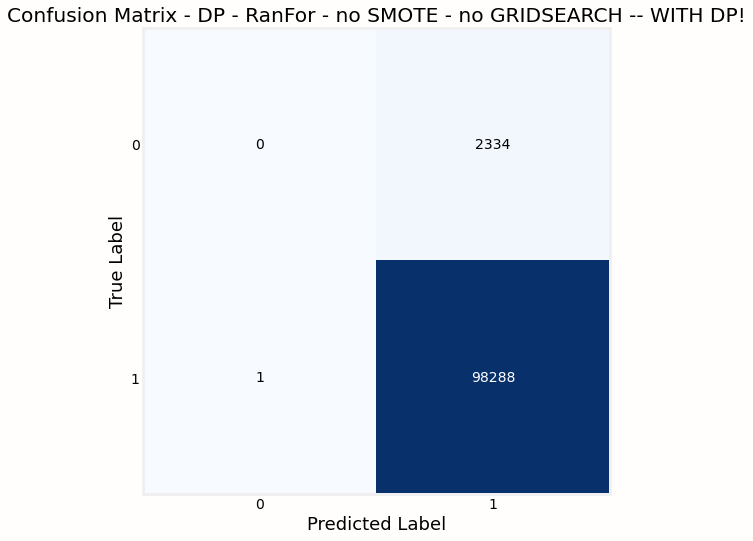

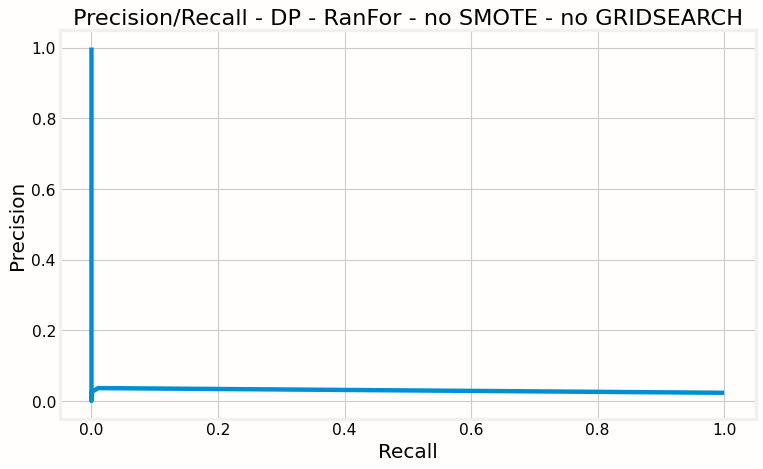

In [23]:
# and classifier regularization.
pca = PCA(random_state=109, n_components=60)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

#model
rf = RandomForestClassifier(epsilon=3.0, n_jobs=2, max_depth=15, n_estimators=10)

# create a pipeline
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("rf", rf)])

# fit model
pipe.fit(X_train, y_train)

# predict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

# print accuracy score
model4 = "DP - RanFor - no SMOTE - no GRIDSEARCH"
model4_acc = accuracy_score(y_test, preds)
model4_recall = recall_score(y_test, preds, pos_label=0)
model4_prec = precision_score(y_test, preds, pos_label=0)
model4_f1 = f1_score(y_test, preds, pos_label=0)
print(f"F1 SCORE: {model4_f1}")
print(f"ACCURACY: {model4_acc}")
print(f"RECALL OF UNINSURED: {model4_recall}")
print(f"PRECISION OF UNINSURED: {model4_prec}")

# plot confusion matrix
conf_mat(y_test, preds, name="DP - RanFor - no SMOTE - no GRIDSEARCH")

# get just class 0 and get pr 
y_scores = [x[0] for x in preds_proba]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=0)

# plot PR curve
pr_curve(precision, recall, name = "DP - RanFor - no SMOTE - no GRIDSEARCH")

#### Random Forrest sklearn baseline model 

We tried the same parameter to train a model without DP and it looks slightly better than one with. 

[Back to Top](#top)


F1 SCORE: 0.011045029736618523
ACCURACY: 0.9768641364300409
RECALL OF UNINSURED: 0.005569837189374464
PRECISION OF UNINSURED: 0.65


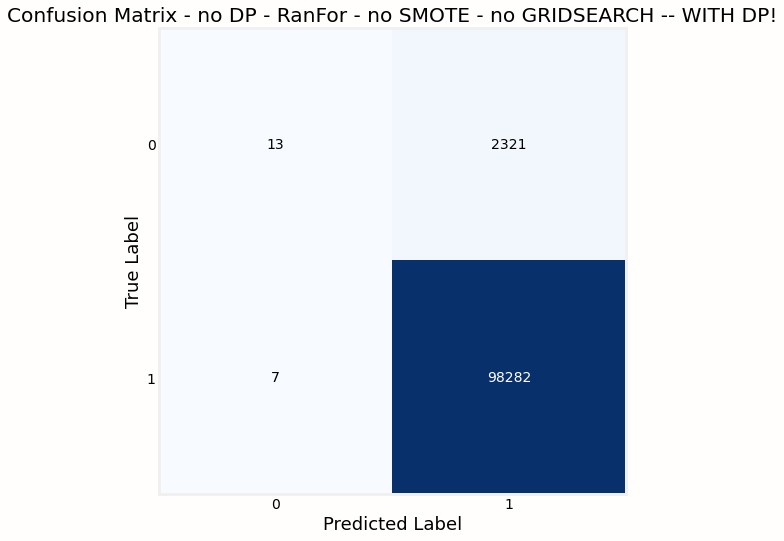

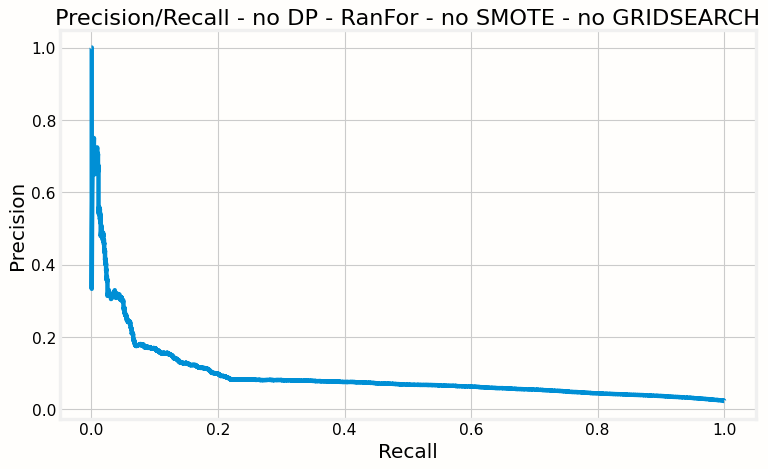

In [24]:
# and classifier regularization.
pca = PCA(random_state=109, n_components=60)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

#model
rf = SKLearnRandomForestClassifier(n_jobs=2, max_depth=15, n_estimators=10)

# create a pipeline
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("rf", rf)])

# fit model
pipe.fit(X_train, y_train)

# predict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

# print accuracy score
skmodel3 = "no DP - RanFor - no SMOTE - no GRIDSEARCH"
skmodel3_acc = accuracy_score(y_test, preds)
skmodel3_recall = recall_score(y_test, preds, pos_label=0)
skmodel3_prec = precision_score(y_test, preds, pos_label=0)
skmodel3_f1 = f1_score(y_test, preds, pos_label=0)
print(f"F1 SCORE: {skmodel3_f1}")
print(f"ACCURACY: {skmodel3_acc}")
print(f"RECALL OF UNINSURED: {skmodel3_recall}")
print(f"PRECISION OF UNINSURED: {skmodel3_prec}")

# plot confusion matrix
conf_mat(y_test, preds, name="no DP - RanFor - no SMOTE - no GRIDSEARCH")

# get just class 0 and get pr 
y_scores = [x[0] for x in preds_proba]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=0)

# plot PR curve
pr_curve(precision, recall, name = "no DP - RanFor - no SMOTE - no GRIDSEARCH")

#### Random Forest Pre GridSearch (with SMOTE)

By adding in SMOTE we see that our model can now predict the uninsured class, but now it is happening with almost every prediction causing our model to have a very high recall of almost 100%, but a terrible precision of just 2%. Attempting to find the balance in training has proved to be quite cumbersome. The random forest models also take much longer to run, making the grid searches more costly to our time. Because of that reason, the majority of the effort was spent on the logistic regression models.

[Back to Top](#top)



F1 SCORE: 0.0
ACCURACY: 0.9767448794013297
RECALL OF UNINSURED: 0.0
PRECISION OF UNINSURED: 0.0


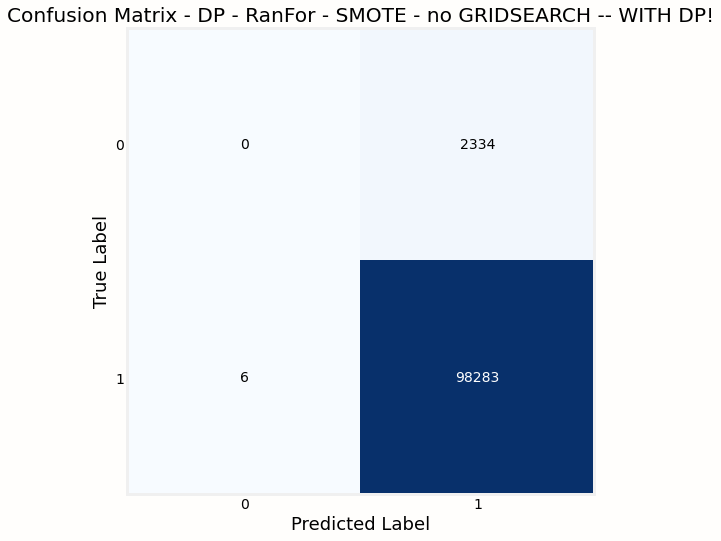

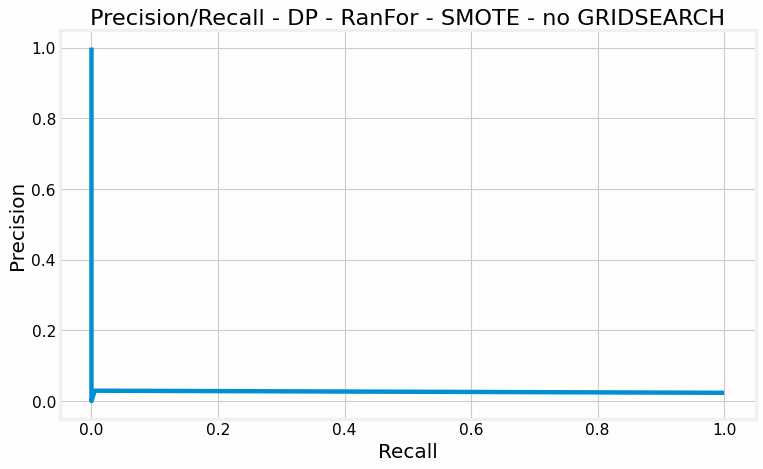

In [25]:
# and classifier regularization.
pca = PCA(random_state=109, n_components=60)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

#model
rf = RandomForestClassifier(epsilon=3.0, n_jobs=2, max_depth=15, n_estimators=10)

# create a pipeline
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("smote", smote), ("rf", rf)])

# fit model
pipe.fit(X_train, y_train)

# predict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

# print accuracy score
model5 = "DP - RanFor - SMOTE - no GRIDSEARCH"
model5_acc = accuracy_score(y_test, preds)
model5_recall = recall_score(y_test, preds, pos_label=0)
model5_prec = precision_score(y_test, preds, pos_label=0)
model5_f1 = f1_score(y_test, preds, pos_label=0)
print(f"F1 SCORE: {model5_f1}")
print(f"ACCURACY: {model5_acc}")
print(f"RECALL OF UNINSURED: {model5_recall}")
print(f"PRECISION OF UNINSURED: {model5_prec}")

# plot confusion matrix
conf_mat(y_test, preds, name="DP - RanFor - SMOTE - no GRIDSEARCH")

# get just class 0 and get pr 
y_scores = [x[0] for x in preds_proba]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=0)

# plot PR curve
pr_curve(precision, recall, name = "DP - RanFor - SMOTE - no GRIDSEARCH")

#### Random Forest sklearn model with SMOTE 

SMOTE seems to have improved the sklearn baseline model by a lot. 

[Back to Top](#top)


F1 SCORE: 0.19155509783728117
ACCURACY: 0.9609930135257346
RECALL OF UNINSURED: 0.19922879177377892
PRECISION OF UNINSURED: 0.18445061483538278


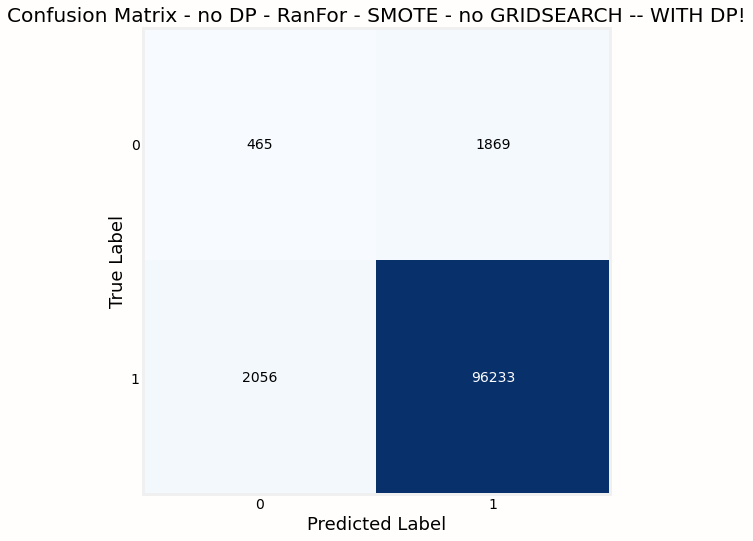

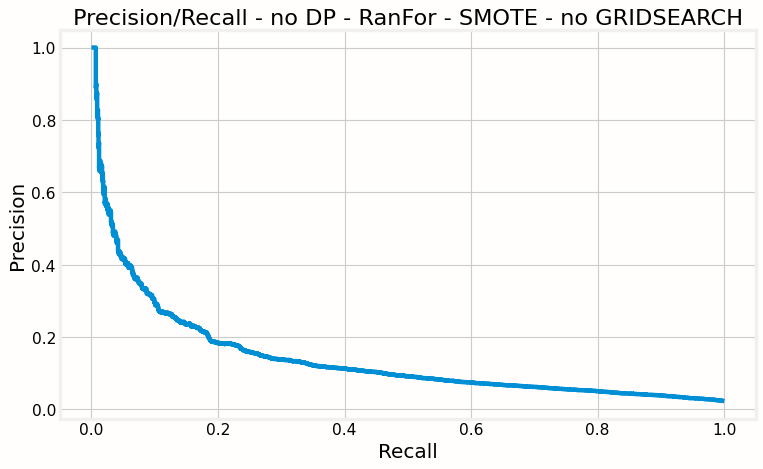

In [26]:
# and classifier regularization.
pca = PCA(random_state=109, n_components=60)

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

#model
rf = SKLearnRandomForestClassifier(n_jobs=2, max_depth=15, n_estimators=10)

# create a pipeline
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("smote", smote), ("rf", rf)])

# fit model
pipe.fit(X_train, y_train)

# predict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

# print accuracy score
skmodel4 = "no DP - RanFor - SMOTE - no GRIDSEARCH"
skmodel4_acc = accuracy_score(y_test, preds)
skmodel4_recall = recall_score(y_test, preds, pos_label=0)
skmodel4_prec = precision_score(y_test, preds, pos_label=0)
skmodel4_f1 = f1_score(y_test, preds, pos_label=0)
print(f"F1 SCORE: {skmodel4_f1}")
print(f"ACCURACY: {skmodel4_acc}")
print(f"RECALL OF UNINSURED: {skmodel4_recall}")
print(f"PRECISION OF UNINSURED: {skmodel4_prec}")

# plot confusion matrix
conf_mat(y_test, preds, name="no DP - RanFor - SMOTE - no GRIDSEARCH")

# get just class 0 and get pr 
y_scores = [x[0] for x in preds_proba]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores, pos_label=0)

# plot PR curve
pr_curve(precision, recall, name = "no DP - RanFor - SMOTE - no GRIDSEARCH")

<a id='summary'></a>

### 5F. Plot Results from All Models

See the below table for the summary of all of the core attempted models. The only model that is worth anything is the Logistic Regression model with SMOTE as we were able to at least get 60% of the uninsured people, however as seen by the precision we had quite a few false positives.

[Back to Top](#top)


In [27]:
# assign data of lists.
data = {'Model Name': [model1, model2, model3, model4, model5, skmodel1, skmodel2, skmodel3, skmodel4], 
        'Accuracy': [model1_acc, model2_acc, model3_acc, model4_acc, model5_acc, skmodel1_acc, skmodel2_acc, skmodel3_acc, skmodel4_acc], 
        'Precision': [model1_prec, model2_prec, model3_prec, model4_prec, model5_prec, skmodel1_prec, skmodel2_prec, skmodel3_prec, skmodel4_prec ], 
        'Recall': [model1_recall, model2_recall, model3_recall, model4_recall, model5_recall,  skmodel1_recall, skmodel2_recall, skmodel3_recall, skmodel4_recall],
        'F1 Score': [model1_f1, model2_f1, model3_f1, model4_f1, model5_f1,  skmodel1_f1, skmodel2_f1, skmodel3_f1, skmodel4_f1]}

results = pd.DataFrame(data)
results.round(3)

,Model Name,Accuracy,Precision,Recall,F1 Score
0,DP - LogReg - no SMOTE - no GRIDSEARCH,0.963,0.091,0.068,0.078
1,DP - LogReg - no SMOTE - GRIDSEARCH,0.974,0.115,0.019,0.033
2,DP - LogReg - SMOTE - GRIDSEARCH,0.793,0.067,0.615,0.121
3,DP - RanFor - no SMOTE - no GRIDSEARCH,0.977,0.000,0.000,0.000
4,DP - RanFor - SMOTE - no GRIDSEARCH,0.977,0.000,0.000,0.000
5,no DP - LogReg - no SMOTE - no GRIDSEARCH,0.977,0.000,0.000,0.000
6,no DP - LogReg - SMOTE - GRIDSEARCH,0.927,0.113,0.314,0.166
7,no DP - RanFor - no SMOTE - no GRIDSEARCH,0.977,0.650,0.006,0.011
8,no DP - RanFor - SMOTE - no GRIDSEARCH,0.961,0.184,0.199,0.192


<a id='conclusion'></a>

## 6. Challenges & Next Steps

The reality of real world datasets is that the majority of work comes before the modeling step, and this dataset was no different. Modeling the highly incomplete, highly imbalanced dataset proved to be quite challenging for the Logistic Regression and Random Forest models. Due to time constraints, we could only try more basic preprocessing methods, and if given more time we would have liked to try continuously testing new methods and see what would work best. There are a number of steps that the team would suggest to test out new strategies for future work on this project. These mainly pertain to pre-processing steps, but also include model specific tasks. This dataset adds an additional challenge of Differential Privacy, which limits the available models to the ones that have already been built by third parties. If given more time we would have loved to write our own differential privacy algorithms as well that could be tailored to the task at hand.

#### Subject Matter Experts (SMEs)

Having an analyst or subject expert on the health insurance information would have been a great help for this project.  If it was feasible, our team would have preferred to spend time sifting through the 250 columns of data, understand them and their importance and identify which ones may be important prior to any pre-processing steps. SMEs are invaluable in these kinds of problems as they can drastically reduce the time it takes to pre-process and clean the data. Consulting with census experts or health care experts could likely help neck down some of the importance in the dataset.

#### Understand what metrics MA can handle, i.e. what rate of False Positives is acceptable

We had to make assumptions with regard to how to optimize our models, but understanding what constrains the state of MA can handle would also be helpful. The model will have False Positives no matter what, but we need to know what rate of False Positives the state can handle and still be able to reach out to the residents the model flags as uninsured. Perhaps their resources are large enough that a significant number of false positives is not necessarily a bad thing. The recall score of the models does fairly well, so we are finding the uninsured residents; the issue is that we are also finding a lot of the insured ones in these predictions as well. Understanding the state's constraints would prove helpful to have goals in mind, and metrics to optimize toward.

#### Class Imbalance & High Dimensionality 

Class imbalance and the sheer number of predictors proved to be the biggest challenges in modeling the dataset. Numerous other ML techniques will need to be delved into in order to try and improve the models here, especially since PCA did not prove to be an adequate solution based on our model's results.  Feature selection, down-sampling the insured class, and other pre-processing steps *could* help improve modeling.

#### Deeper Dive into Missing Data

Missing data was either thrown out or imputed, but what else could we have learned about this data, were there trends in why some data was missing, could this be engineered into another feature? Given more time, we would need to have a deeper analysis of the missing data, perhaps a study on this alone could prove to be quite useful in this dataset.

#### Computation

With the large dataset computation for training each model was fairly large. Logistic Regression trained quicker than Random Forest, but performing very long grid searches were proving to be very computationally expensive. Due to time constraints it became a challenge to continuously test new techniques with the time the models would take to run. Sub sampling the data or increasing compute performance would both help to increase the turnaround time on testing models.

#### Tuning Privacy Budget 

We have used one epsilon value for training all of the models in this notebook. However, as the lecture has shown, privacy values can impact the performance of a differentially private model by a lot especially when there is not enough data. Given more time, we would like to dig deeper into the epsilon values impact on our models of choice and its real life privacy implications.

#### Evaluating Privacy Guarantees of our Model
Finally, we did what we could to ensure differential privacy was being upheld in our training process, but how do we evaluate if we were successful?  Given more time, we need to experiment with and test the privacy that was provided by the diffpriv library we used.



[Back to Top](#top)

<a id='reference'></a>

## 7. References

#### United States Census Bureau / PUMS data 

- Introduction: https://www.census.gov/programs-surveys/acs/microdata/access.html
- Raw database: https://www2.census.gov/programs-surveys/acs/data/pums/2020/5-Year/
- Column descriptions: https://data.census.gov/mdat/#/search?ds=ACSPUMS5Y2020

#### IBM / Diffprivlib: differential-privacy-library

- GitHub repository: https://github.com/IBM/differential-privacy-library
- Library page: https://diffprivlib.readthedocs.io/en/latest/

#### Smartnoise

- Webpage: https://smartnoise.org/

#### Harvard / Privacy Tools Project and COMPSCI 109B

- Privacy Tools Project: https://privacytools.seas.harvard.edu/differential-privacy
- COMPSCI 109B video lecture: https://dcegather.canvas.harvard.edu/courses/102556

[Back to Top](#top)
